In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import grid_search
import requests
import json
from category import Category
from database import Database
from playlist import Playlist
from track import Track
from artist import Artist
from genre import Genre

from collections import Counter
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data Import And Processing

In [328]:
# Connect to database and load all playlist data
db = Database()
genresByPopularity = list(Genre.getByPopularity(db))
playlists = Playlist.loadAll(db)


In [329]:
# Get a list of all genres for all artists, frequency in the list
# indicates how many times those genres appear
def getAllGenres():
    genres = []
    for playlist in playlists:
        for track in playlist.tracks:
            if track.artist1:
                genres.extend(track.artist1.genres)
            if track.artist2:
                genres.extend(track.artist2.genres)
            if track.artist3:
                genres.extend(track.artist3.genres)
    return genres

# Remove all playlists containing "This is:" indicating that it features
# a single artist
def filterAllSingleArtist(playlists):
    multiArtistPlaylists = []
    for playlist in playlists:
        if 'this is:' not in playlist.name.decode('UTF-8').lower():
            multiArtistPlaylists.append(playlist)
    return multiArtistPlaylists

# Get a list of unique genres, sorted by their frequency
def genresByCount(allGenres):
    genresCount = Counter(allGenres)
    genresList = list(genresCount.items())
    # Sort the genres list by frequency
    genresList.sort(key=lambda x: -x[1])
    genres = [genre[0] for genre in genresList]
    # An empty string has been creeping into here
    if '' in genres:
        genres.remove('')
    return genres

# Get a list of all genres by frequency
genres = genresByCount(getAllGenres())
# Filter out single artist playlists
playlists = filterAllSingleArtist(playlists)
# Should have 1423 playlists
print(len(playlists))

1423


In [330]:
# For an arbitrary list of genres, remove empty strings and sort by frequency
def cleanGenres(artistGenres, limit=None):
    artistGenres = list(set(artistGenres))
    if '' in artistGenres:
        artistGenres.remove('')
    artistGenres.sort(key=lambda x: genres.index(x))
    if limit:
        return artistGenres[:limit]
    return artistGenres

# Test the genre cleaner
# should print ['pop', 'rock', 'jazz', 'deep dutch hip hop']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock']))
# should print ['pop', 'rock']
print(cleanGenres(['deep dutch hip hop', 'pop', '', 'jazz', '', 'rock'], 2))

['pop', 'rock', 'jazz', 'deep dutch hip hop']
['pop', 'rock']


In [331]:
# Clean all of the genres for all artist objects
for playlist in playlists:
    for track in playlist.tracks:
        if track.artist1:
            track.artist1.genres = cleanGenres(track.artist1.genres)
        if track.artist2:
            track.artist2.genres = cleanGenres(track.artist2.genres)
        if track.artist3:
            track.artist3.genres = cleanGenres(track.artist3.genres)

In [332]:
# Function to find a "most representative" genre for each playlist
# Uses some number of most popular genres per artist, limits the return
# to the most popular
def getPlaylistGenres(playlist, numPerArtist=1, limit=2):
    playlistGenres = []
    for track in playlist.tracks:
        if track.artist1:
            playlistGenres.extend(track.artist1.genres[:numPerArtist])
        if track.artist2:
            playlistGenres.extend(track.artist2.genres[:numPerArtist])
        if track.artist3:
            playlistGenres.extend(track.artist3.genres[:numPerArtist])
    
    playlistGenres = genresByCount(playlistGenres)[:limit]
    return playlistGenres


In [333]:
# Get a list of most relevant genres per playlist
for playlist in playlists:
    playlist.genres = getPlaylistGenres(playlist, 2, 4)

In [334]:
#Remove playlists without genres
playlistsWithGenres = []
removed = []
for playlist in playlists:
    if len(playlist.genres) != 0:
        playlistsWithGenres.append(playlist)
    else:
        removed.append(playlist)
playlists = playlistsWithGenres


In [335]:
# Store a single main genre for each playlist
for playlist in playlists:
    playlist.mainGenre = playlist.genres[0]

In [217]:
# Create DataFrame with playlist properties

def flattenPlaylist(playlist, get_raw=False):
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    explicit = []
    trackDurations = []
    for track in playlist.tracks:
        explicit.append(track.explicit)
        trackDurations.append(track.duration)
        trackPopularities.append(track.popularity)
        if track.artist1:
            artistPopularities.append(track.artist1.popularity)
            artistFollowers.append(track.artist1.followers)
            artistViews.append(track.artist1.views)
        if track.artist2:
            artistPopularities.append(track.artist2.popularity)
            artistFollowers.append(track.artist2.followers)
            artistViews.append(track.artist2.views)
        if track.artist3:
            artistPopularities.append(track.artist3.popularity)
            artistFollowers.append(track.artist3.followers)
            artistViews.append(track.artist3.views)
    
    if get_raw:
        return {'num_tracks': len(playlist.tracks), 'explicit': explicit, 'track_durations': trackDurations, 'track_popularities': trackPopularities, 'artist_popularities': artistPopularities, 'artist_followers': artistFollowers, 'artist_views': artistViews, 'playlist_followers': playlist.followers}

    else:
        return [len(playlist.tracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), playlist.followers]
    
headers = ['num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']

flattened = [flattenPlaylist(playlist) for playlist in playlists]
df = pd.DataFrame(flattened, columns=headers)

msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

ytrain = data_train.iloc[:,-1]
Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

ytest = data_test.iloc[:,-1]
Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)

In [218]:
data_train.head()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,564114.696970,1.215937e+06,5210412,664189.848485,9.247158e+05,4443917,16084
1,60,0.000000,276171.466667,14.683333,9.319320,43,50.064516,15.590393,84,229765.435484,6.352567e+05,4424637,814916.241935,2.916046e+06,23129006,17864
2,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,93890.384615,1.894456e+05,924636,117589.221154,2.852078e+05,2671926,256892
3,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,308746.795699,5.616157e+05,3464127,334099.494624,7.646027e+05,5936516,668423
5,100,0.090000,221997.560000,52.180000,19.351165,82,70.069307,10.787100,88,918662.831683,1.328977e+06,5531913,915880.584158,1.857412e+06,9171862,37924


In [219]:
data_train.describe()

,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
count,1066.000000,1066.000000,1.066000e+03,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03,1.066000e+03
mean,53.465291,0.095342,2.678049e+05,38.333422,15.690876,66.474672,58.448137,13.227592,83.128518,7.990650e+05,1.123603e+06,5.333558e+06,1.153645e+06,1.638567e+06,7.653516e+06,2.047268e+05
std,25.925230,0.190694,1.778282e+05,16.998035,5.817321,18.208697,16.494977,4.606186,15.174212,1.056643e+06,1.221606e+06,5.356635e+06,1.248940e+06,1.426252e+06,6.207141e+06,5.288051e+05
min,6.000000,0.000000,3.962875e+04,0.000000,0.000000,0.000000,8.261682,0.000000,14.000000,6.574766e+01,0.000000e+00,1.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,31.000000,0.000000,2.146420e+05,26.661667,11.781630,58.250000,48.440721,10.438702,77.000000,7.636810e+04,1.646028e+05,9.024690e+05,2.100520e+05,4.645133e+05,2.464931e+06,1.156250e+03
50%,50.000000,0.013246,2.327583e+05,39.325076,16.324892,70.000000,59.485337,12.969113,86.000000,3.513495e+05,6.125451e+05,3.257736e+06,6.523719e+05,1.208525e+06,5.838257e+06,3.210950e+04
75%,70.000000,0.090909,2.560072e+05,49.640000,19.994029,78.000000,70.222222,15.787512,95.000000,1.117812e+06,1.668014e+06,9.090011e+06,1.735973e+06,2.608295e+06,1.227502e+07,1.681100e+05
max,100.000000,1.000000,2.507284e+06,90.300000,34.226306,100.000000,93.818182,37.446410,100.000000,6.050277e+06,5.189948e+06,1.538430e+07,7.878729e+06,7.067183e+06,2.312901e+07,1.108252e+07


In [220]:
# Build a dataframe with statistics for each genre
mainGenres = list(set([playlist.mainGenre for playlist in playlists]))

# Build a dictionary to get a set of playlists by their "mainGenre"
genresToPlaylists = defaultdict(list)
for playlist in playlists:
    genresToPlaylists[playlist.mainGenre].append(playlist)

df_rows = []
for genre, genrePlaylists in genresToPlaylists.items():
    playlistsData = []
    numTracks = []
    explicit = []
    trackDurations = []
    trackPopularities = []
    artistPopularities = []
    artistFollowers = []
    artistViews = []
    playlistFollowers = []
    for playlist in genrePlaylists:
        data = flattenPlaylist(playlist, True)
        numTracks.append(data['num_tracks'])
        explicit.extend(data['explicit'])
        trackDurations.extend(data['track_durations'])
        trackPopularities.extend(data['track_popularities'])
        artistPopularities.extend(data['artist_popularities'])
        artistFollowers.extend(data['artist_followers'])
        artistViews.extend(data['artist_views'])
        playlistFollowers.append(data['playlist_followers'])
    df_rows.append([genre, len(genrePlaylists), np.sum(numTracks), np.mean(numTracks), np.mean(explicit), np.mean(trackDurations), np.mean(trackPopularities), np.std(trackPopularities), np.max(trackPopularities), np.mean(artistPopularities), np.std(artistPopularities), np.max(artistPopularities), np.mean(artistFollowers), np.std(artistFollowers), np.max(artistFollowers), np.mean(artistViews), np.std(artistViews), np.max(artistViews), np.mean(playlistFollowers)])

headers = ['genre', 'num_playlists', 'num_tracks', 'mean_num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']
df_genres = pd.DataFrame(df_rows, columns=headers)

In [221]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,j-pop,1,50,50.0,0.04,249977.9000,39.880,9.584654,64,43.225806,9.696057,68,14467.370968,4.954938e+04,386250,31253.693548,107785.112245,612743,101289.0
1,technical death metal,1,50,50.0,0.20,249374.2600,19.020,8.998867,43,24.240000,10.521521,48,6520.200000,9.449999e+03,44502,73312.960000,262534.488125,1360499,23642.0
2,tech house,2,80,40.0,0.00,401996.6625,37.575,9.432358,54,43.628319,9.141169,73,19897.769912,2.995655e+04,215191,47176.858407,57305.104597,346293,136544.5
3,reggaeton,1,100,100.0,0.31,234952.8600,59.900,17.973592,92,77.502538,16.166213,98,922474.147208,1.137550e+06,5299984,223190.593909,586599.473370,4253957,50497.0
4,early music,1,50,50.0,0.00,232985.5400,20.860,7.307558,42,25.007407,11.632328,59,871.733333,2.044643e+03,13536,14217.592593,30883.941919,141791,34963.0


# Exploratory Data Analysis

In [231]:
# Correlation heatmap
import seaborn as sns
mid = df['followers']
df.drop(labels=['followers'], axis=1,inplace = True)
df.insert(0, 'followers', mid)
#
#  We use Pandas' 'corr' method to compute pairwise correlation of column (defaults to Pearson)
#  Use Xtrain which omits the unnormalized continuous predictors and the response variable
plt.figure(figsize = (15,15))
corr = df.corr()


cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


,followers,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views
followers,1,0.21,0.12,-0.068,0.4,-0.12,0.27,0.22,-0.16,0.18,0.1,0.15,0.19,0.064,0.1,0.12
num_tracks,0.21,1,-0.072,0.06,0.03,-0.19,0.044,-0.13,-0.031,-0.034,-0.16,-0.082,0.0084,-0.15,-0.094,0.032
mean_track_explicit,0.12,-0.072,1,-0.091,0.31,0.13,0.28,0.38,0.00071,0.31,0.45,0.46,0.43,0.34,0.36,0.28
mean_track_popularities,-0.068,0.06,-0.091,1,-0.31,-0.29,-0.38,-0.34,-0.03,-0.33,-0.13,-0.16,-0.17,-0.074,-0.099,-0.11
mean_track_duration,0.4,0.03,0.31,-0.31,1,0.28,0.84,0.79,-0.31,0.65,0.54,0.58,0.58,0.39,0.47,0.45
std_track_popularities,-0.12,-0.19,0.13,-0.29,0.28,1,0.62,0.58,0.2,0.6,0.39,0.45,0.43,0.34,0.44,0.42
max_track_popularities,0.27,0.044,0.28,-0.38,0.84,0.62,1,0.81,0.0063,0.82,0.51,0.61,0.64,0.38,0.51,0.52
mean_artist_popularities,0.22,-0.13,0.38,-0.34,0.79,0.58,0.81,1,-0.22,0.8,0.75,0.73,0.71,0.64,0.65,0.6
std_artist_popularities,-0.16,-0.031,0.00071,-0.03,-0.31,0.2,0.0063,-0.22,1,0.21,-0.17,0.011,0.048,-0.16,0.029,0.053
max_artist_popularities,0.18,-0.034,0.31,-0.33,0.65,0.6,0.82,0.8,0.21,1,0.56,0.69,0.73,0.44,0.59,0.61


#### What does a heatmap reveal about relationships between Playlist popularity and Playlist Artist/Track attributes?

The heatmap above was created to see if we could discern any relationships between a Playlist's popularity, i.e., the number of Playlist Followers, and Artist and/or Track attributes associated with and averaged over a Playlist. <br>

Track Popularity has the strongest positive correlation (0.28) associated with Playlist popularity, followed by Artist Popularity (0.22).

####  Which Genres have the most Track counts?

Examining all tracks in all the playlists, we plot the top 40 Genres with the most Track counts.  The most frequently occuring Genres in the playlists are generalized Genres of current, popular music such as 'pop', 'rock' and 'rap' and combinations of these general Genres ('pop rap', 'pop rock') vs Genres representing a very specific music niche, such as 'skiffle'.

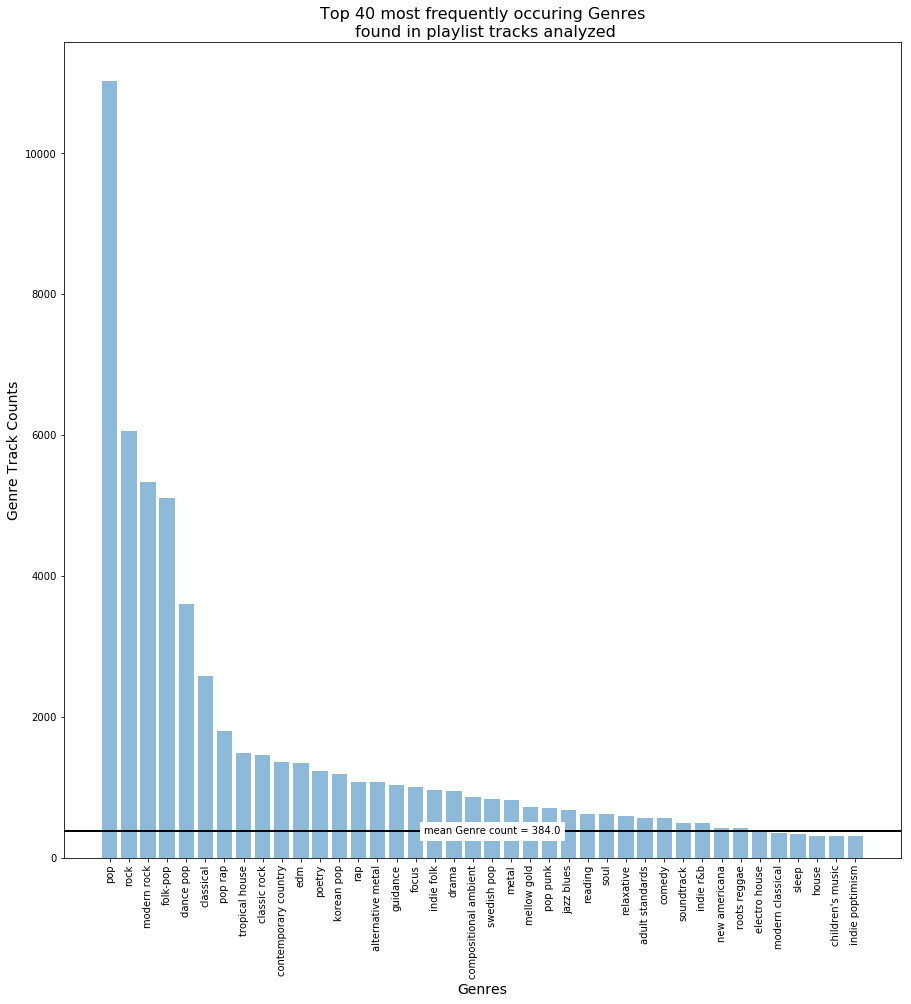

In [223]:
# EDA - Visualize Genres with most the most number of tracks tagged with that Genre
df_genres_sorted = df_genres.sort_values('num_tracks',ascending=False)
asd = df_genres_sorted.head(n=40)
mean_genre = np.round(np.mean(df_genres.num_tracks))
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['num_tracks'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.num_tracks), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.num_tracks), 'mean Genre count = '+str(mean_genre), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most frequently occuring Genres\n found in playlist tracks analyzed", fontsize = 16)
plt.ylabel("Genre Track Counts", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

####  Which Genres have more Explicit lyrics on average?  

We plotted the top 40 most Explicit Genres, considering only the Genres having a significant Track count, where significant is defined as a Genre having the mean number of Tracks (371) or more associated with it. =

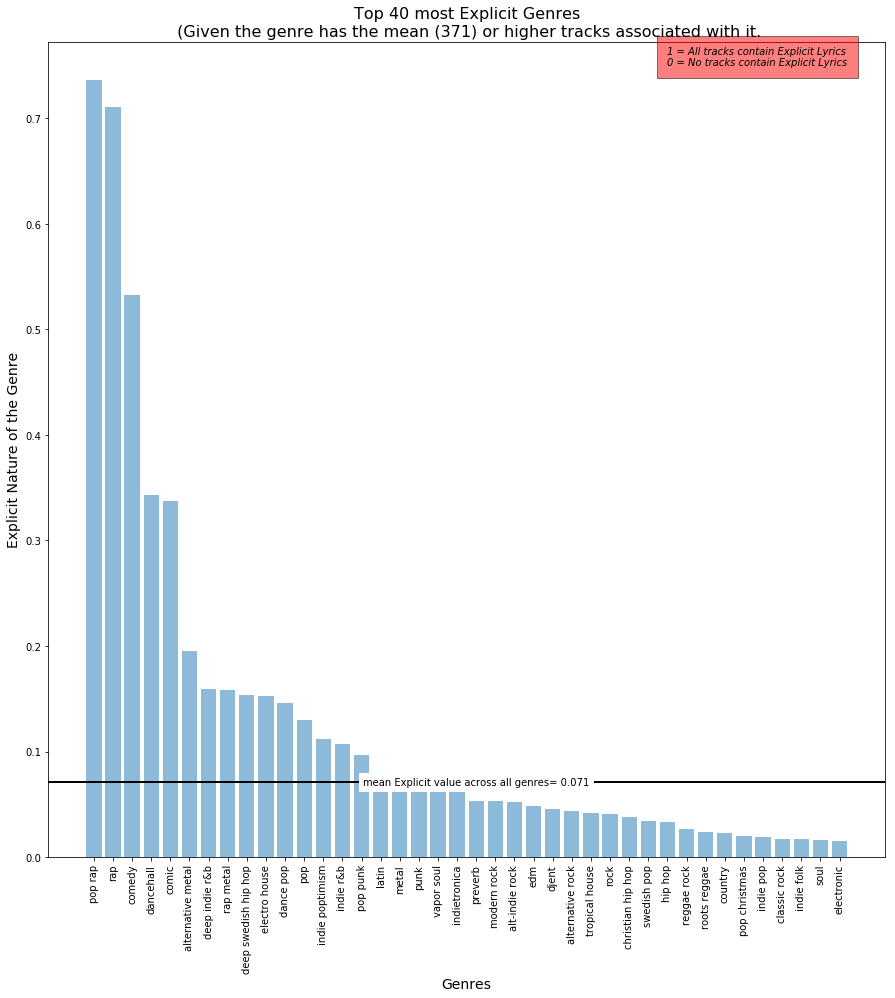

In [224]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_tracks'] > 100].sort_values('mean_track_explicit',ascending=False).head(n=40)
mean_explicit = np.around(np.mean(df_genres.mean_track_explicit), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['mean_track_explicit'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.mean_track_explicit), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.mean_track_explicit), 'mean Explicit value across all genres= '+str(mean_explicit), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Top 40 most Explicit Genres\n (Given the genre has the mean (371) or higher tracks associated with it.",  
          fontsize = 16)
plt.ylabel("Explicit Nature of the Genre", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.text(30, 0.75, '1 = All tracks contain Explicit Lyrics\n0 = No tracks contain Explicit Lyrics', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
plt.show()

#### Are there any trends where similar genres have more explicit lyrics on average?  

In general, most Genre associated Tracks don't have Explicit lyrics, the average value being 0.059 (closer to 0).  'rap' and 'hip hop' (two closely related Genres) dominate the 20 positions with significantly larger 'Explicit' values than most genres.  Two comedy related genres also appear in the top 20.

#### Which genres have the most followers

In [225]:
df_genres.head()

,genre,num_playlists,num_tracks,mean_num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,j-pop,1,50,50.0,0.04,249977.9000,39.880,9.584654,64,43.225806,9.696057,68,14467.370968,4.954938e+04,386250,31253.693548,107785.112245,612743,101289.0
1,technical death metal,1,50,50.0,0.20,249374.2600,19.020,8.998867,43,24.240000,10.521521,48,6520.200000,9.449999e+03,44502,73312.960000,262534.488125,1360499,23642.0
2,tech house,2,80,40.0,0.00,401996.6625,37.575,9.432358,54,43.628319,9.141169,73,19897.769912,2.995655e+04,215191,47176.858407,57305.104597,346293,136544.5
3,reggaeton,1,100,100.0,0.31,234952.8600,59.900,17.973592,92,77.502538,16.166213,98,922474.147208,1.137550e+06,5299984,223190.593909,586599.473370,4253957,50497.0
4,early music,1,50,50.0,0.00,232985.5400,20.860,7.307558,42,25.007407,11.632328,59,871.733333,2.044643e+03,13536,14217.592593,30883.941919,141791,34963.0


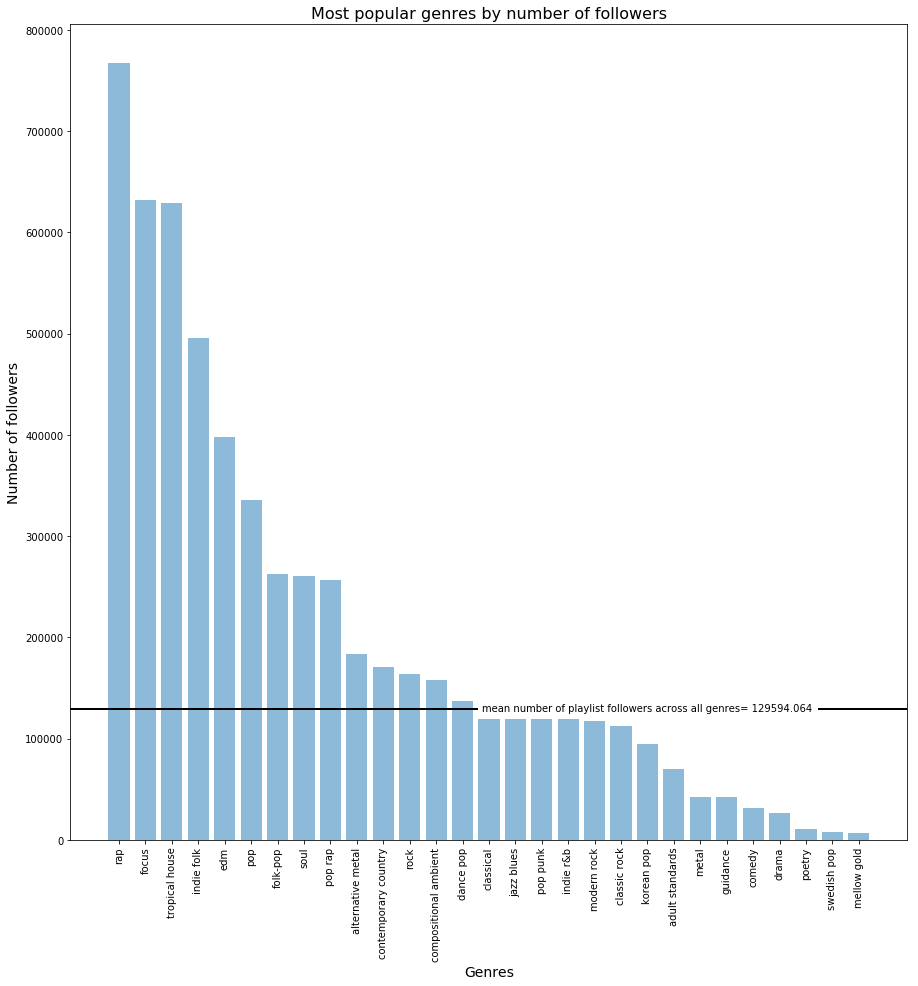

In [226]:
# EDA - Explore which Genres are more likely to have Explicit Lyrics.
# Most genres aren't explicit in nature based on mean value.
asd = df_genres[df_genres['num_playlists'] > 10].sort_values('followers',ascending=False).head(n=40)
mean_followers = np.around(np.mean(df_genres.followers), decimals = 3)
objects  = tuple(list(asd['genre']))
y_pos = np.arange(asd.shape[0])
performance = list(asd['followers'])
plt.figure(figsize=(15,15))
plt.xticks(y_pos, objects, rotation='vertical')
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.axhline(y = np.mean(df_genres.followers), linewidth=2, color = 'k')
plt.text(20, np.mean(df_genres.followers), 'mean number of playlist followers across all genres= '+str(mean_followers), fontsize=10, va='center', ha='center', backgroundcolor='w')
plt.title("Most popular genres by number of followers", fontsize = 16)
plt.ylabel("Number of followers", fontsize = 14)
plt.xlabel("Genres", fontsize = 14)
plt.show()

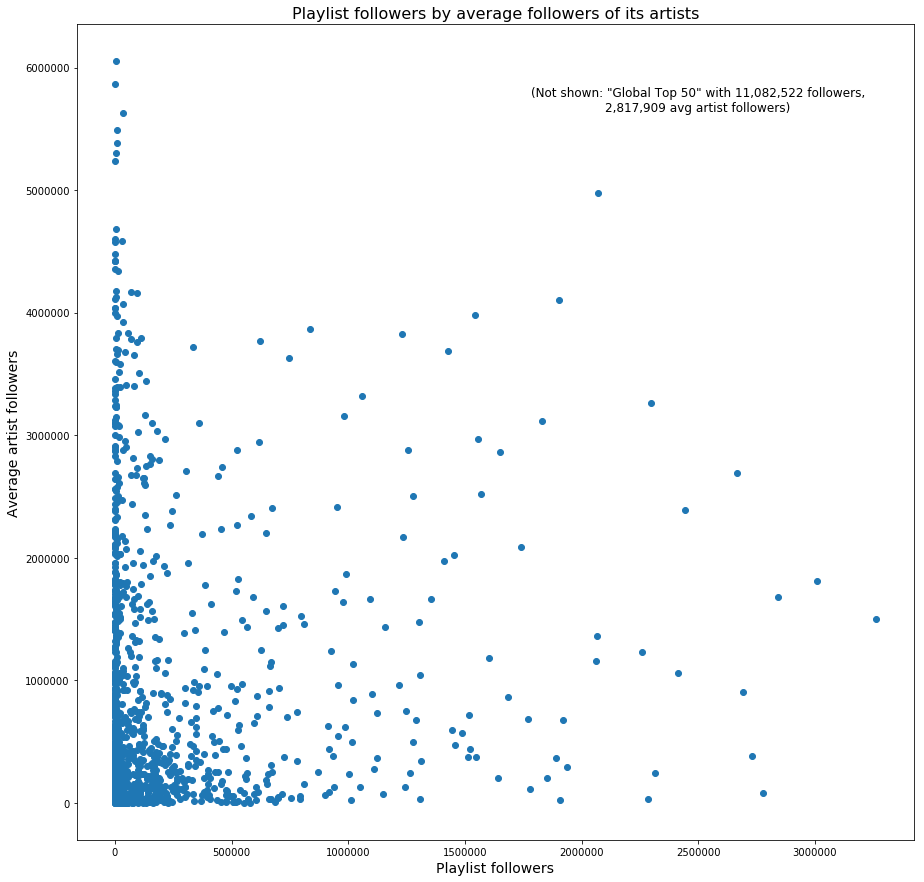

In [192]:
meanArtistFollowers = []
playlistFollowers = []
for playlist in playlists:
    
    artistFollowers = []
    for track in playlist.tracks:
        if track.artist1:
            artistFollowers.append(track.artist1.followers)
        if track.artist2:
            artistFollowers.append(track.artist2.followers)
        if track.artist3:
            artistFollowers.append(track.artist3.followers)
    if playlist.id != 617:
        meanArtistFollowers.append(np.mean(artistFollowers))
        playlistFollowers.append(playlist.followers)

plt.figure(figsize=(15,15))
plt.scatter(playlistFollowers, meanArtistFollowers)
plt.ylabel("Average artist followers", fontsize = 14)
plt.xlabel("Playlist followers", fontsize = 14)
plt.figtext(.7,.8,'(Not shown: \"Global Top 50\" with 11,082,522 followers,\n2,817,909 avg artist followers)', fontsize=12, ha='center')

plt.title("Playlist followers by average followers of its artists", fontsize = 16)
plt.show()


In [193]:
# Load all artists from database
db.cur.execute("SELECT * FROM artists")
rows = db.cur.fetchall()
artists = [Artist.fromDB(row) for row in rows]
print(len(artists))

27135


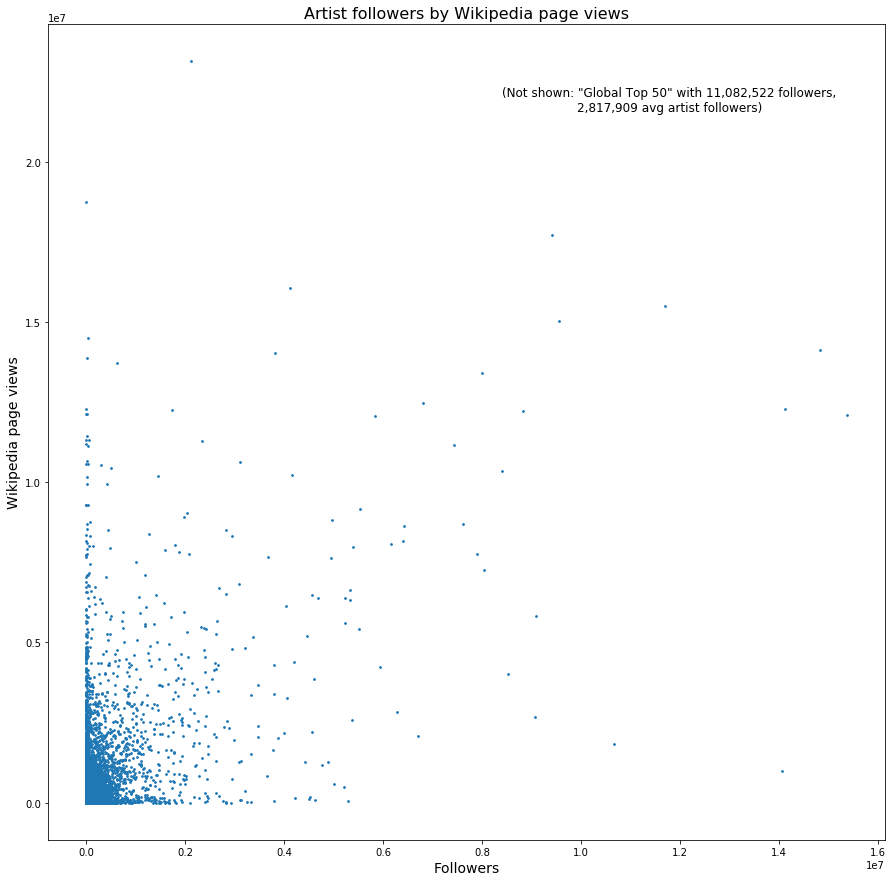

In [201]:
plt.figure(figsize=(15,15))
plt.scatter([artist.followers for artist in artists], [artist.views for artist in artists], s=3)
plt.ylabel("Wikipedia page views", fontsize = 14)
plt.xlabel("Followers", fontsize = 14)
plt.figtext(.7,.8,'(Not shown: \"Global Top 50\" with 11,082,522 followers,\n2,817,909 avg artist followers)', fontsize=12, ha='center')
plt.title("Artist followers by Wikipedia page views", fontsize = 16)
plt.show()

# Clustering Genres By Co-Occurrence

#### Distance Calculating functions

In [233]:
# Get a count of all genres as they occur in all data in the dataset
genresCount = Counter(getAllGenres())

# Get a list of all unique genres in the dataset, ordered by the frequency that they appear in
genres = genresByCount(getAllGenres())


# "Distance" function for calculating the similarity of genres, based on their co-occurence in playlists
# 0 indicates that the two genres never appear together. 1 indicates that they always appear together
def distance(genre1, genre2):
    if genre1 == genre2:
        return 0.0
    # A count measuring how often one genre or the other appears
    opportunities = 0.0
    # A count measuring how often one genre appears without the other. A "missed" opportunity
    missed = 0.0
    
    # The distance should be penalized less if an extremely popular genre, like 'pop'
    # appears without a very rare genre like 'icelandic fairy pop' (not a real genre)
    # Therefore, we need to figure out which genre is most and least popular
    mostPopular = genre2 if genres.index(genre1) > genres.index(genre2) else genre1
    leastPopular = genre1 if genres.index(genre1) > genres.index(genre2) else genre2
    
    # Weight the distance penalties by the relative occurences of the genres
    unpopular_missed_penalty = float(genresCount[leastPopular] / genresCount[mostPopular])
    popular_missed_penalty = np.reciprocal(unpopular_missed_penalty)
    
    for playlist in playlists:
        if leastPopular in playlist.genres or mostPopular in playlist.genres:
            if mostPopular not in playlist.genres:
                # The most least genre occurs, but the most popular one does not.
                # This is a larger penalty
                opportunities += popular_missed_penalty
                missed += popular_missed_penalty
            elif leastPopular not in playlist.genres:
                # The least popular genre occurs, but the most popular one does not.
                # This is a smaller penalty
                opportunities += unpopular_missed_penalty
                missed += unpopular_missed_penalty
            else:
                # They're both in it -- big win. 
                opportunities += 1
    retDist = float(missed / opportunities)
    if np.isnan(retDist):
        return 1.0
    return retDist


# Calculate the distance between two groups of genres by averaging 
def distance_between_groups(group1, group2, return_0_if_any_common_genres=False):
    if group1 == group2:
        return 0.0
    avgs = []
    for genre1 in group1:
        for genre2 in group2:
            if return_0_if_any_common_genres:
                if genre1 == genre2:
                    return 0.0
            avgs.append(distance(genre1, genre2))
    return np.mean(avgs)

In [234]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import FeatureAgglomeration


# Get a list of unique genres in no particular order
playlistGenres = []
for playlist in playlists:
    playlistGenres.append(playlist.mainGenre)
playlistGenres = list(set(playlistGenres))

distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2))
    distance_matrix.append(row)

n_clusters = [5, 10, 15, 20, 25, 30]
print("Agglomerative clustering silhouette scores, by number of clusters")
for n in n_clusters:
    agglom = AgglomerativeClustering(n_clusters=n, affinity='precomputed', linkage='average')
    agglom.fit(distance_matrix)
    score = silhouette_score(distance_matrix, agglom.labels_, metric='precomputed')
    print(str(n)+" : "+str(score))

eps_vals = [.001, .001, .005, .0075, .01, .05, .075, .1, .12, .15, .2]
print("DBSCAN silhouette scores by eps value")
for eps_val in eps_vals:
    dbscan = DBSCAN(eps=eps_val, min_samples=1, metric='precomputed', algorithm='brute')
    dbscan.fit(distance_matrix)
    score = silhouette_score(distance_matrix, dbscan.labels_, metric='precomputed')
    print(str(eps_val)+" : "+str(score))
    

Agglomerative clustering silhouette scores, by number of clusters
5 : 0.0069615187278
10 : 0.0155085272748
15 : 0.0314560731312
20 : 0.0509903096263
25 : 0.0684712690754
30 : 0.0856414387887
DBSCAN silhouette scores by eps value
0.001 : 0.0205128205128
0.001 : 0.0205128205128
0.005 : 0.0205128205128
0.0075 : 0.0205128205128
0.01 : 0.0205128205128
0.05 : 0.0300313594281
0.075 : 0.0300313594281
0.1 : 0.0300313594281
0.12 : 0.0569166094875
0.15 : 0.0617799601859
0.2 : 0.0844787184828


In [243]:
from itertools import chain
from itertools import groupby
import networkx
from networkx.algorithms.components.connected import connected_components

# Turns the output of a clustering algorithm with groups and labels and returns a list of items
# Assumes that the items within each group is a list itself, and merges all of the lists together
def get_labeled_lists(labels, groups):
    labels_dict = dict()
    unsorted= []
    for i in range(len(labels)):
        if str(labels[i]) not in labels_dict:
            labels_dict[str(labels[i])] = []
        if str(labels[i]) == '-1':
            # Better luck with these guys next time... 
            # Add them as individual items to the return list
            unsorted.append(groups[i])
        else:
            labels_dict[str(labels[i])].extend(groups[i])
    return_groups = [value for key, value in labels_dict.items() if len(value) != 0]
    return_groups.extend(unsorted)
    return return_groups

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

def group_lists(listOfList):
    G = to_graph(listOfList)
    component_list = list(connected_components(G))
    return [list(x) for x in component_list]

def match_groups(groups, eps, big_groups_limit=20, directly_compare=False):
    
    big_groups = []
    little_groups = []
    # We want to avoid groups that are too big. Pull the larger groups aside
    # and only cluster the smaller groups
    for group in groups:
        if len(group) > big_groups_limit:
            big_groups.append(group)
        else:
            little_groups.append(group)

    if directly_compare:
        pairsToCombine = []
        for i in range(len(little_groups)):
            row = []
            for j in range(i, len(little_groups)):
                if i != j:
                    if  distance_between_groups(little_groups[i], little_groups[j]) < eps:
                        pairsToCombine.append([i, j])
        indexGroupsToCombine = group_lists(pairsToCombine)
        
        combinedIndexes = []
        combined = []
        for indexesList in indexGroupsToCombine:
            tmp = []
            for index in indexesList:
                tmp.extend(little_groups[index])
                combinedIndexes.append(index)
            combined.append(tmp)
            
        # Add all that weren't grouped
        for i in range(len(little_groups)):
            if i not in combinedIndexes:
                combined.append(little_groups[i])
        combined.extend(big_groups)
        return combined
    else:
                    
        distances = []
        for genre_group1 in little_groups:
            row = []
            for genre_group2 in little_groups:
                row.append(distance_between_groups(genre_group1, genre_group2))
            distances.append(row)
        
        dbscan = DBSCAN(eps=eps, min_samples=1, metric='precomputed', algorithm='auto')
        dbscan.fit(distances)
        groups = get_labeled_lists(dbscan.labels_, little_groups)
    
    groups.extend(big_groups)

    return groups



In [244]:
print(len(playlistGenres))

195


In [245]:
playlistGenres = list(set([playlist.mainGenre for playlist in playlists]))

distance_matrix = []
for genre1 in playlistGenres:
    row = []
    for genre2 in playlistGenres:
        row.append(distance(genre1, genre2))
    distance_matrix.append(row)

# DB scan mostly does a good job, but splits some groups into too large of a category
# and others cannot be sufficiently grouped

dbscan = DBSCAN(eps=.5, min_samples=1, metric='precomputed', algorithm='brute')
dbscan.fit(distance_matrix)

label_dict = defaultdict(list)
unsorted = []

for i in range(len(dbscan.labels_)):
    label_dict[str(dbscan.labels_[i])].append(playlistGenres[i])
    if dbscan.labels_[i] == -1:
        unsorted.append([playlistGenres[i]])
groups = [value for key, value in label_dict.items()]
groups.extend(unsorted)

print(len(groups))
for group in groups:
    print(group)


155
['swedish pop']
['soundtrack', 'scorecore']
['indie rockism']
['indie poptimism']
['disco']
['soul']
['deep swedish hip hop']
['progressive deathcore', 'post-screamo', 'rap metal']
['rock-and-roll']
['grime']
['theme']
['world']
['italian arena pop']
['latin alternative']
['antiviral pop', 'video game music']
['new americana']
['contemporary jazz']
['underground hip hop']
['preverb']
['brill building pop']
['jazz fusion']
['nu jazz']
['modern rock']
['house', 'tech house']
['classic funk rock']
['deep swedish indie pop']
['pagan black metal']
['trap francais']
['deep indie r&b']
['drum and bass']
['new wave pop']
['irish folk', 'celtic']
['death metal']
['post rock']
['reggae rock', 'roots reggae', 'reggae']
['finnish dance pop']
['deep danish pop']
['pop rap', 'rap', 'hip hop', 'nerdcore']
['stoner rock']
['mellow gold']
['urban contemporary']
['indie folk']
['fourth world']
['moombahton']
['europop']
['deep dutch hip hop']
['drone folk']
['wind ensemble']
['swedish punk']
['filte

In [246]:
print(len(groups))
groups2 = match_groups(groups, .75)
print("LEN GROUPS 2:")
print(len(groups2))
for group in groups2:
    print(group)



155
LEN GROUPS 2:
120
['progressive house']
['adult standards', 'cool jazz', 'vocal jazz', 'free jazz', 'jazz blues']
['gypsy jazz']
['bossa nova']
['latin alternative']
['swedish punk']
['deep dutch hip hop']
['moombahton']
['focus', 'relaxative', 'christian relaxative', 'compositional ambient']
['hardcore techno']
['neo mellow']
['oratory']
['destroy techno', 'electro house', 'indietronica']
['grime']
['minimal']
['underground hip hop']
['indie r&b', 'footwork']
['deep melodic euro house']
['post rock']
['tropical']
['country', 'contemporary country']
['comic', 'poetry', 'comedy', 'judaica', 'reading']
['antiviral pop', 'video game music']
['italian arena pop']
['house', 'tech house', 'deep house']
['fingerstyle', 'classify']
['modern classical']
['reggaeton', 'latin']
['alternative rock']
['new wave pop']
['mellow gold', 'rock', 'classic rock']
['classical guitar']
['psychedelic rock']
['christian music', 'christian alternative rock']
['contemporary jazz', 'nu jazz', 'fourth world']

In [251]:
groups3 = match_groups(groups2, .85, 10)
print("LEN GROUPS 3:")
print(len(groups2))
for group in groups3:
    print(group)
print(len(groups3))

LEN GROUPS 3:
120
['alt-indie rock']
['drama']
['stoner rock']
['tropical house', 'pop', 'dance pop', 'edm', 'kompa']
['oratory']
['sleep', 'environmental']
['gothic metal', 'progressive metal', 'djent']
['healing', 'native american']
['modern rock', 'indie folk', 'folk-pop']
['wind ensemble', 'classical', 'brass ensemble']
['indie jazz']
['finnish dance pop']
['moombahton']
['underground hip hop']
['folk rock']
['gospel', 'christian hip hop']
['mellow gold', 'rock', 'classic rock']
['deep danish pop', 'filter house']
['destroy techno', 'electro house', 'indietronica']
['neo mellow']
['tropical']
['drone folk']
['movie tunes']
['norwegian indie']
['reggaeton', 'latin']
['pop punk', 'punk']
['dancehall']
['fluxwork', 'float house']
['electronic', 'trip hop']
['minimal', 'modern classical']
['jazz fusion']
['progressive house']
['europop']
['outlaw country', 'country christmas']
['theme']
['new wave pop']
['alternative hip hop', 'chillhop']
['singer-songwriter']
['fingerstyle', 'classify

In [252]:
groups4 = match_groups(groups3, .9, 10, True)
print("LEN GROUPS 3:")
print(len(groups3))
for group in groups4:
    print(group)
print(len(groups4))

LEN GROUPS 3:
106
['indie psych-rock', 'preverb']
['comic', 'poetry', 'comedy', 'judaica', 'reading', 'drama', 'hollywood']
['finnish dance pop', 'tropical house', 'pop', 'dance pop', 'edm', 'kompa']
['drum and bass', 'focus', 'relaxative', 'christian relaxative', 'compositional ambient']
['rock-and-roll', 'brill building pop', 'motown', 'folk rock']
['modern rock', 'indie folk', 'folk-pop', 'indie pop', 'singer-songwriter', 'norwegian indie']
['indie jazz', 'contemporary jazz', 'nu jazz', 'fourth world', 'electronic', 'trip hop']
['mellow gold', 'rock', 'classic rock', 'christian music', 'christian alternative rock', 'alternative rock', 'pop christmas']
['antiviral pop', 'video game music', 'soundtrack', 'scorecore']
['reggaeton', 'latin', 'tropical']
['nursery', "children's music", "children's christmas", 'movie tunes']
['post rock', 'dream pop']
['soul', 'classic funk rock', 'soul christmas', 'disco']
['alt-indie rock']
['stoner rock']
['oratory']
['sleep', 'environmental']
['gothic

In [253]:
groups5 = match_groups(groups4, .97, 10, True)
print("LEN GROUPS 5:")
print(len(groups5))
for group in groups5:
    print(group)

LEN GROUPS 5:
46
['indie psych-rock', 'preverb', 'alt-indie rock']
['finnish dance pop', 'tropical house', 'pop', 'dance pop', 'edm', 'kompa', 'indie rockism', 'indie poptimism', 'vapor soul', 'deep hardstyle', 'alternative hip hop', 'chillhop', 'strut', 'indie r&b', 'footwork', 'deep indie r&b', 'underground hip hop', 'korean pop', 'destroy techno', 'electro house', 'indietronica', 'pop rap', 'rap', 'hip hop', 'nerdcore']
['post rock', 'dream pop', 'drum and bass', 'focus', 'relaxative', 'christian relaxative', 'compositional ambient', 'fingerstyle', 'classify', 'classical guitar', 'minimal', 'modern classical']
['swing', 'rock-and-roll', 'brill building pop', 'motown', 'folk rock']
['wonky', 'modern rock', 'indie folk', 'folk-pop', 'indie pop', 'singer-songwriter', 'norwegian indie', 'bluegrass', 'progressive bluegrass', 'new americana', 'stomp and holler']
['swedish jazz', 'deep swedish indie pop', 'swedish pop', 'deep swedish hip hop', 'swedish indie rock', 'swedish idol pop', 'ind

In [382]:
genreGroups = groups5

# Regression

In [383]:
def playlistToGenreGroup(playlist):
    for i in range(len(genreGroups)):
        if playlist.mainGenre in genreGroups[i]:
            # Return groups index
            return i
    print("NOT FOUND: "+playlist.mainGenre)

def getTrackSimilarityScore(playlist):
    # Compute track similiarity score for a playlist defined as:
    #  (number of tracks in most popular genre group) / (all tracks)
    numGenreTracks = 0
    allTracks = 0
    # collect all genres associated with a playlist's tracks
    for track in playlist.tracks:
        genres = []
        if track.artist1 and track.artist1.genres:
            genres.extend(track.artist1.genres)
        if track.artist2 and track.artist2.genres:
            genres.extend(track.artist2.genres)
        if track.artist3 and track.artist3.genres:
            genres.extend(track.artist3.genres)
        # find the most occuring genre --> gCount[0]
        gCount = genresByCount(genres)
        # Is the track in most popular genre group?
        if gCount and playlist.genreGroup:
            if gCount[0] in groups[playlist.genreGroup]:
                numGenreTracks += 1
        allTracks += 1
    return numGenreTracks/allTracks

In [384]:
for playlist in playlists:
    playlist.genreGroup = playlistToGenreGroup(playlist)
    playlist.similarity = getTrackSimilarityScore(playlist)

In [320]:
def get_dataframe(playlists=playlists):
    playlistRows = []
    for playlist in playlists:
        row = flattenPlaylist(playlist)
        row.insert(0, playlist.similarity)
        row.insert(0, playlist.genreGroup)
        row.insert(0, playlist.name)
        playlistRows.append(row)
    headers = ['playlist_name', 'playlist_genre_group', 'track_similarity','num_tracks', 'mean_track_explicit', 'mean_track_popularities', 'mean_track_duration', 'std_track_popularities', 'max_track_popularities', 'mean_artist_popularities', 'std_artist_popularities', 'max_artist_popularities','mean_artist_followers', 'std_artist_followers', 'max_artist_followers', 'mean_artist_views', 'std_artist_views', 'max_artist_views', 'followers']

    df_spotify = pd.DataFrame(playlistRows, columns = headers)
    return df_spotify
df_spotify = get_dataframe()

In [343]:
#  Q: How many NaNs are there in each column with missing data?
#  A:  None, so we won't impute
missing_columns = df_spotify.columns[df_spotify.isnull().any()]
df_spotify[missing_columns].isnull().sum()

Series([], dtype: float64)

In [269]:
df_spotify.head()

,playlist_name,playlist_genre_group,track_similarity,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,b'The Refugee Playlist',1,0.0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,5.641147e+05,1.215937e+06,5210412,6.641898e+05,9.247158e+05,4443917,16084
1,b'Best of John Peel Sessions',6,0.0,60,0.000000,276171.466667,14.683333,9.319320,43,50.064516,15.590393,84,2.297654e+05,6.352567e+05,4424637,8.149162e+05,2.916046e+06,23129006,17864
2,b'New Noise',4,0.0,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,9.389038e+04,1.894456e+05,924636,1.175892e+05,2.852078e+05,2671926,256892
3,b'Digging Now',4,0.0,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,3.087468e+05,5.616157e+05,3464127,3.340995e+05,7.646027e+05,5936516,668423
4,b'Rock Solid',6,0.0,50,0.180000,247698.080000,66.880000,12.457351,81,77.320000,5.880272,91,1.728723e+06,1.431618e+06,6157956,1.716571e+06,1.831774e+06,8068727,944837


In [270]:
def split_data(df):
    # Split data into 25-75 train and test data
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < 0.75
    data_train = df[msk]
    data_test = df[~msk]
    
    # set y data to just the last column, remove last column from the predictor sets
    ytrain = data_train.iloc[:,-1]
    Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

    ytest = data_test.iloc[:,-1]
    Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)
    return (ytrain, Xtrain, ytest, Xtest)

In [371]:
def lasso_ridge(ytrain, Xtrain, ytest, Xtest, plotTitle, plot=True):
#
#  Fit a regression model using using Lasso and RidgeCV 
#  and plot R^2 over alpha hyper parameters
#

    # Added additional alpha values around 10 in order to get more 
    # precise data around this location
    alphas = [.00001, .0001, .001, .01, .1, 1, 5, 8, 10, 12, 20, 30, 35,
              40, 45, 50, 100, 1000, 10000, 100000]
    r2s = {'ridge':[], 'lasso':[]}

    for alpha in alphas:
        # Fit Lasso regression and add r2 results to r2 object
        # Note:  normalize=True yielded lower R^2
        lasso = Lasso(alpha=alpha, normalize=True, fit_intercept=True, max_iter=2000)
        lasso.fit(Xtrain, ytrain)
        lasso_preds = lasso.predict(Xtest)
        r2s['lasso'].append(r2_score(ytest, lasso_preds))
    
        # Fit Ridge regression add r2 results to r2 object
        ridge = Ridge(alpha=alpha, normalize=True, fit_intercept=True, max_iter=2000)
        ridge.fit(Xtrain, ytrain)
        ridge_preds = ridge.predict(Xtest)
        r2s['ridge'].append(r2_score(ytest, ridge_preds))
            # Get the best r2 score found for both ridge and lasso
        winningRidge = np.argmax(r2s['ridge'])
        winningLasso = np.argmax(r2s['lasso'])
    if plot:
        # Use a semilogx plot to display alpha values on a normalized scale
        plt.figure(figsize=(8,8))
        plt.semilogx(alphas, r2s['ridge'], label='Ridge')
        plt.semilogx(alphas, r2s['lasso'], label='Lasso')
        plt.ylabel("R2 Score")
        plt.xlabel("Alpha")
        plt.title(plotTitle)
        plt.legend()
        plt.show()

        print("Best Lasso: "+str(alphas[winningLasso])+" score: "+str(r2s['lasso'][winningLasso]))
        print("Best Ridge: "+str(alphas[winningRidge])+" score: "+str(r2s['ridge'][winningRidge]))


    return (r2s['ridge'][winningRidge], r2s['lasso'][winningLasso])

In [272]:
df_spotify.head()

,playlist_name,playlist_genre_group,track_similarity,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,b'The Refugee Playlist',1,0.0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,5.641147e+05,1.215937e+06,5210412,6.641898e+05,9.247158e+05,4443917,16084
1,b'Best of John Peel Sessions',6,0.0,60,0.000000,276171.466667,14.683333,9.319320,43,50.064516,15.590393,84,2.297654e+05,6.352567e+05,4424637,8.149162e+05,2.916046e+06,23129006,17864
2,b'New Noise',4,0.0,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,9.389038e+04,1.894456e+05,924636,1.175892e+05,2.852078e+05,2671926,256892
3,b'Digging Now',4,0.0,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,3.087468e+05,5.616157e+05,3464127,3.340995e+05,7.646027e+05,5936516,668423
4,b'Rock Solid',6,0.0,50,0.180000,247698.080000,66.880000,12.457351,81,77.320000,5.880272,91,1.728723e+06,1.431618e+06,6157956,1.716571e+06,1.831774e+06,8068727,944837


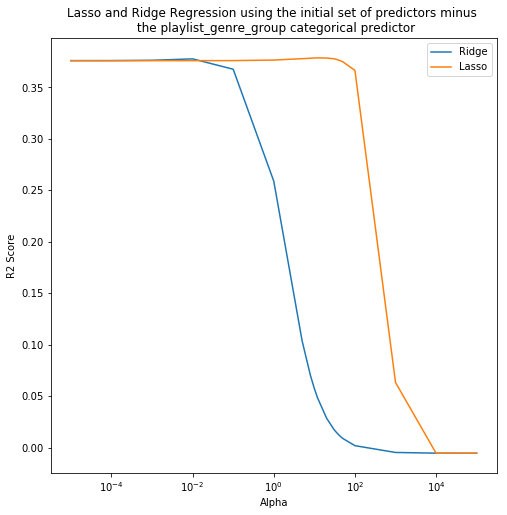

Best Lasso: 12 score: 0.378780508462
Best Ridge: 0.01 score: 0.377821626663


(0.37782162666330921, 0.37878050846238975)

In [385]:
#
#  Fit a regression model using using Lasso and RidgeCV on the initial set of 
#  predictors minus the 'playlist_genre_group' integer based categorical predictor
#  and plot R^2 over alpha hyper parameters
#
def lasso_ridge_no_genre(df_spotify, plot=True):
    # Remove 'playlist_name' column
    df_spotify.drop('playlist_name', axis=1, inplace = True)
    df_spotify.drop('playlist_genre_group', axis=1, inplace = True)
    title = "Lasso and Ridge Regression using the initial set of predictors minus \n the playlist_genre_group categorical predictor"
    # Get all four sets from split data function
    ytrain, Xtrain, ytest, Xtest = split_data(X_reduced)
    return lasso_ridge(ytrain, Xtrain, ytest, Xtest, title, plot)

lasso_ridge_no_genre(get_dataframe())


/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


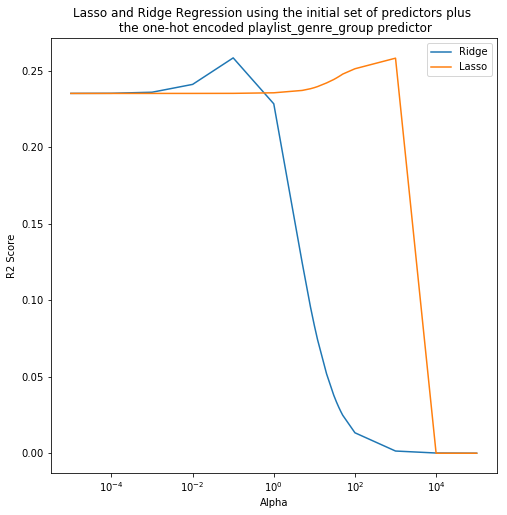

Best Lasso: 1000 score: 0.258340642179
Best Ridge: 0.1 score: 0.258526434588


(0.25852643458840563, 0.25834064217917052)

In [386]:
#  One-hot encode the 'playlist_genre_group' predictor
#
#  Fit a regression model using using Lasso and RidgeCV on the initial set of 
#  predictors plus the one-hot encoded the 'playlist_genre_group' predictor
#  and plot R^2 over alpha hyper parameters
#

def lasso_ridge_one_hot(df_spotify, plot=True):
    df_spotify.drop('playlist_name', axis=1, inplace = True)

    df_spotify = pd.get_dummies(df_spotify, columns = ['playlist_genre_group'])

    #  Remove the last dummy variable, 'Playlist_Genre_Group_45.0', since it's redundant 
    remove_cols = ['playlist_genre_group_42.0']
    df_spotify = df_spotify[df_spotify.columns.difference(remove_cols)]

    # Put 'Playlist_Followers' column back to the end of the dataframe and
    # 'Playlist_Name' column at the beginning of the dataframe
    cols = list(df_spotify)
    cols.insert(len(df_spotify) - 1, cols.pop(cols.index('followers')))

    df_spotify = df_spotify.reindex(columns= cols)

    # Get all four sets from split data function
    ytrain, Xtrain, ytest, Xtest = split_data(df_spotify)
    title = "Lasso and Ridge Regression using the initial set of predictors plus \n the one-hot encoded playlist_genre_group predictor"
    return lasso_ridge(ytrain, Xtrain, ytest, Xtest, title, plot)

lasso_ridge_one_hot(get_dataframe()) 

In [276]:
df_spotify.head()

,playlist_genre_group,track_similarity,num_tracks,mean_track_explicit,mean_track_popularities,mean_track_duration,std_track_popularities,max_track_popularities,mean_artist_popularities,std_artist_popularities,max_artist_popularities,mean_artist_followers,std_artist_followers,max_artist_followers,mean_artist_views,std_artist_views,max_artist_views,followers
0,1,0.0,22,0.090909,227756.227273,42.590909,19.106541,67,61.848485,16.507338,89,5.641147e+05,1.215937e+06,5210412,6.641898e+05,9.247158e+05,4443917,16084
1,6,0.0,60,0.000000,276171.466667,14.683333,9.319320,43,50.064516,15.590393,84,2.297654e+05,6.352567e+05,4424637,8.149162e+05,2.916046e+06,23129006,17864
2,4,0.0,100,0.070000,210771.360000,46.430000,12.488599,76,53.240385,13.572098,78,9.389038e+04,1.894456e+05,924636,1.175892e+05,2.852078e+05,2671926,256892
3,4,0.0,88,0.090909,217517.454545,53.329545,13.680379,76,64.408602,12.860907,100,3.087468e+05,5.616157e+05,3464127,3.340995e+05,7.646027e+05,5936516,668423
4,6,0.0,50,0.180000,247698.080000,66.880000,12.457351,81,77.320000,5.880272,91,1.728723e+06,1.431618e+06,6157956,1.716571e+06,1.831774e+06,8068727,944837


/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


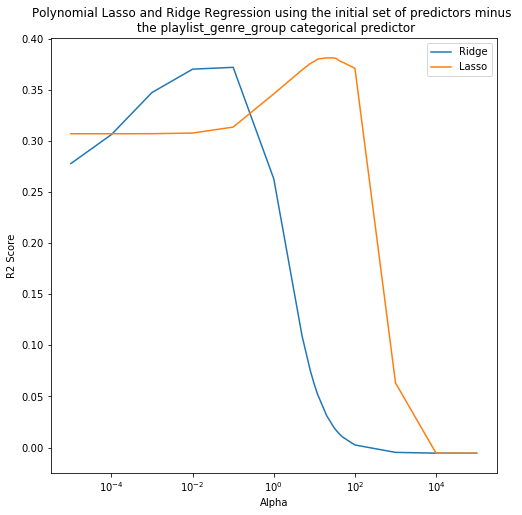

Best Lasso: 20 score: 0.381231466297
Best Ridge: 0.1 score: 0.371993073591


(0.37199307359052647, 0.38123146629681937)

In [387]:
def lasso_ridge_poly(df_spotify, plot=True):
    df_spotify.drop('playlist_name', axis=1, inplace = True)
    df_spotify.drop('playlist_genre_group', axis=1, inplace = True)
    ytrain, Xtrain, ytest, Xtest = split_data(df_spotify)

    # Predictors
    numeric_cols = ['track_similarity', 'num_tracks', 'mean_track_explicit',
                    'mean_track_popularities', 'mean_track_duration', 'std_track_popularities',
                    'max_track_popularities', 'mean_artist_popularities','std_artist_popularities',
                    'max_artist_popularities', 'mean_artist_followers', 'std_artist_followers',
                    'max_artist_followers', 'mean_artist_views', 'std_artist_views',
                    'max_artist_views']
    Xtrain_poly = Xtrain1.copy()
    Xtest_poly =  Xtest1.copy()

    # Add exponent columns for all numeric columns of the form:
    # 'colname_exponent'
    for numeric_col in numeric_cols:
        Xtrain_poly[numeric_col+'_2'] = Xtrain[numeric_col]**2
        Xtrain_poly[numeric_col+'_3'] = Xtrain[numeric_col]**3
        Xtrain_poly[numeric_col+'_4'] = Xtrain[numeric_col]**4

        Xtest_poly[numeric_col+'_2'] = Xtest[numeric_col]**2
        Xtest_poly[numeric_col+'_3'] = Xtest[numeric_col]**3
        Xtest_poly[numeric_col+'_4'] = Xtest[numeric_col]**4

    # Get all four sets from split data function
    title = "Polynomial Lasso and Ridge Regression using the initial set of predictors minus \n the playlist_genre_group categorical predictor"
    return lasso_ridge(ytrain1, Xtrain_poly, ytest1, Xtest_poly, title, plot)
    

lasso_ridge_poly(get_dataframe())



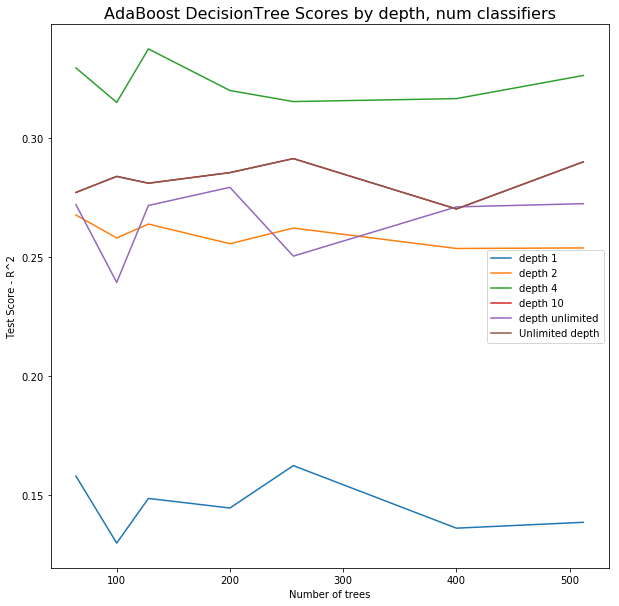

Best score for depth 1 is 0.162506204943 with 256 trees
Best score for depth 2 is 0.267750751824 with 64 trees
Best score for depth 4 is 0.337497686948 with 128 trees
Best score for depth 10 is 0.291436679697 with 256 trees
Best score for depth unlimited is 0.279368181582 with 200 trees


0.33749768694828786

In [388]:
#
#  Fit a AdaBoost regression model using decision tree regressor
#
def decision_tree_ada(df_spotify, plot=True):
    df_spotify.drop('playlist_name', axis=1, inplace = True)
    df_spotify.drop('playlist_genre_group', axis=1, inplace = True)
    ytrain, Xtrain, ytest, Xtest = split_data(df_spotify)
    
    depths = [1, 2, 4, 10, None]
    tree_nums = [64, 100, 128, 200, 256, 400, 512]

    scores = []
    for depth in depths:
        depth_scores = []
        for tree_num in tree_nums:
            dtc = DecisionTreeRegressor(max_depth=depth)
            ada = AdaBoostRegressor(dtc, learning_rate=0.05, n_estimators=tree_num)
            ada.fit(Xtrain2, ytrain2)
            ada_preds = ada.predict(Xtest2)
            depth_scores.append(ada.score(Xtest2, ytest2))
        scores.append(depth_scores)

    if plot:
        # Change None to 'unlimited' for printing
        depths[4] = 'unlimited'
        plt.figure(figsize = (10, 10))
        for i in range(len(depths)):
            plt.plot(tree_nums, scores[i], label='depth '+str(depths[i]))

        plt.plot(tree_nums, scores[3], label='Unlimited depth')
        plt.title('AdaBoost DecisionTree Scores by depth, num classifiers', fontsize = 16)
        plt.xlabel('Number of trees')
        plt.ylabel('Test Score - R^2')
        plt.legend(loc='best')
        plt.show()
        bestScores = []
    for i in range(len(depths)):
        bestIdx = np.argmax(scores[i])
        bestScores.append(scores[i][bestIdx])
        print("Best score for depth "+str(depths[i])+" is "+str(scores[i][bestIdx])+" with "+str(tree_nums[bestIdx])+" trees")
    return np.max(bestScores)
decision_tree_ada(get_dataframe())

In [284]:
# Compute R^2 for all models in one plot with optimal hyperparameters
#
# Fit Lasso and Ridge regression with optimal alpha hyperparameter 
# selected by CV earlier Reduced feature set
lassobest = Lasso(alpha = bestLasso, normalize = True, fit_intercept = True)
lassobest.fit(Xtrain1, ytrain1)
lassobest_preds = lassobest.predict(Xtest1)
print ("Reduced feature set - not one-hot encoding Features")
print ("---------------------------------------------------")
print ('Best Lasso Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest1, 
                                                                             lassobest_preds)))

ridgebest = Ridge(alpha = bestRidge, normalize=True, fit_intercept=True)
ridgebest.fit(Xtrain1, ytrain1)
ridgebest_preds = ridgebest.predict(Xtest1)
print ('Best Ridge Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest1, 
                                                                             ridgebest_preds)))

print ("===========================")

# Fit Lasso and Ridge regression with optimal alpha hyperparameter 
# selected by CV earlier with feature set using one-hot encoding
bestLassoOneHot = Lasso(alpha = bestLassoOneHot, normalize = True, fit_intercept = True)
bestLassoOneHot.fit(Xtrain2, ytrain2)
bestLassoOneHot_preds = bestLassoOneHot.predict(Xtest2)

print ("Full feature set - Using one-hot encoding Features")
print ("--------------------------------------------------")
print ('Best Lasso Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest2,
                                                                             bestLassoOneHot_preds)))

bestRidgeOneHot = Ridge(alpha = bestRidge, normalize=True, fit_intercept=True)
bestRidgeOneHot.fit(Xtrain2, ytrain2)
bestRidgeOneHot_preds = bestRidgeOneHot.predict(Xtest2)
print ('Best Ridge Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest2,
                                                                             bestRidgeOneHot_preds)))
print ("===========================")
print ("Polynomial Regression - Reduced feature set - With 4th order polynomial terms ")
print ("------------------------------------------------------------------------------")

# Fit Lasso and Ridge regression with optimal alpha hyperparameter 
# selected by CV earlier Reduced feature set
lassoPolybest = Lasso(alpha = bestPolyLasso, normalize = True, fit_intercept = True)
lassoPolybest.fit(Xtrain1, ytrain1)
lassoPolybest_preds = lassoPolybest.predict(Xtest1)
print ('Best Lasso Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest1, 
                                                                             lassoPolybest_preds)))

ridgePolybest = Ridge(alpha = bestPolyRidge, normalize=True, fit_intercept=True)
ridgePolybest.fit(Xtrain1, ytrain1)
ridgePolybest_preds = ridgePolybest.predict(Xtest1)
print ('Best Ridge Regression Test Accuracy Score:  {0:.4f}'.format(r2_score(ytest1, 
                                                                             ridgePolybest_preds)))

print ("===========================")
print ("ADABoost - Full feature set - Using one-hot encoding Features")
print ("-------------------------------------------------------------")
dtc = DecisionTreeRegressor(max_depth = None)
adabest = AdaBoostRegressor(dtc, learning_rate=0.05, n_estimators = 400)
adabest.fit(Xtrain2, ytrain2)
adabest_preds = adabest.predict(Xtest2)
print ('Best ADABoost Test Accuracy Score:  {0:.4f}'.format(adabest.score(Xtest2, ytest2)))

Reduced feature set - not one-hot encoding Features
---------------------------------------------------
Best Lasso Regression Test Accuracy Score:  0.2583
Best Ridge Regression Test Accuracy Score:  0.2536
Full feature set - Using one-hot encoding Features
--------------------------------------------------
Best Lasso Regression Test Accuracy Score:  0.2583
Best Ridge Regression Test Accuracy Score:  0.2585
Polynomial Regression - Reduced feature set - With 4th order polynomial terms 
------------------------------------------------------------------------------
Best Lasso Regression Test Accuracy Score:  0.2583
Best Ridge Regression Test Accuracy Score:  0.2269
ADABoost - Full feature set - Using one-hot encoding Features
-------------------------------------------------------------
Best ADABoost Test Accuracy Score:  0.3168


In [285]:
def get_summary_df(X, y):
    ols = sm.OLS(y, X).fit()
    
    summary_data = ols.summary().tables[1].data
    header = summary_data.pop(0)
    header[0] = 'predictor'

    # We get the data as strings -- convert here. 
    for i in range(len(summary_data)):
        summary_data[i][1] = float(summary_data[i][1])
        summary_data[i][2] = float(summary_data[i][2])
        summary_data[i][3] = float(summary_data[i][3])
        summary_data[i][4] = float(summary_data[i][4])
        summary_data[i][5] = float(summary_data[i][5])
        summary_data[i][6] = float(summary_data[i][6])
        
    summary_df = pd.DataFrame(summary_data, columns=header)
    return summary_df

In [286]:
# Use entire dataframe
y = df_spotify['followers']
X = df_spotify.copy()
X.drop('followers', axis=1, inplace = True)
X_intercept = sm.add_constant(X)
summary_df = get_summary_df(X_intercept, y)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(60)


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
2,num_tracks,2606.0106,507.633,5.134,0.000,1610.206,3601.816
6,std_track_popularities,-21710.0000,3680.632,-5.897,0.000,-28900.000,-14500.000
5,mean_track_duration,12420.0000,2052.035,6.055,0.000,8399.494,16500.000
0,const,-242100.0000,103000.000,-2.339,0.019,-445000.000,-39100.000
11,mean_artist_followers,-0.1014,0.043,-2.340,0.019,-0.186,-0.016
8,mean_artist_popularities,3661.3911,2266.533,1.615,0.106,-784.780,8107.563
3,mean_track_explicit,87180.0000,72100.000,1.208,0.227,-54300.000,229000.000
13,max_artist_followers,0.0104,0.009,1.145,0.252,-0.007,0.028
10,max_artist_popularities,-1998.5589,2044.054,-0.978,0.328,-6008.303,2011.185
9,std_artist_popularities,3736.4668,4110.851,0.909,0.364,-4327.635,11800.000


## Regression After Removing Outliers

In [337]:
def get_dataframe_outliers(follower_threshold):
    playlist_outliers = [playlist for playlist in playlists if playlist.followers < follower_threshold]
    return get_dataframe(playlist_outliers)

In [370]:
print(len(playlists))

1415


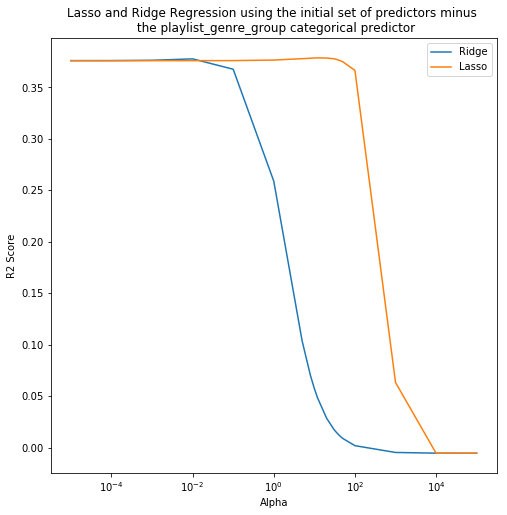

Best Lasso: 12 score: 0.378780508462
Best Ridge: 0.01 score: 0.377821626663


(0.37782162666330921, 0.37878050846238975)

In [367]:
lasso_ridge_no_genre(get_dataframe_outliers(500000))

/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


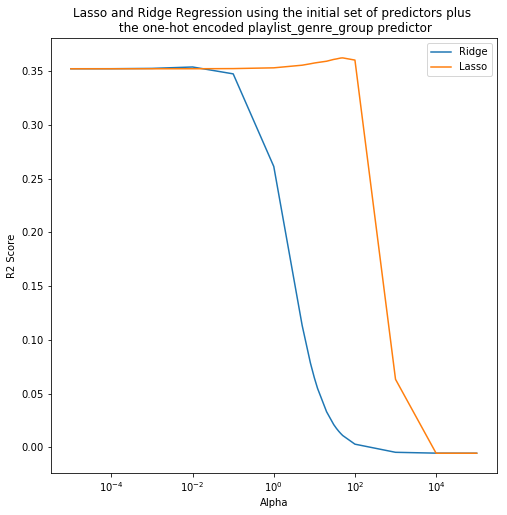

Best Lasso: 50 score: 0.362268179164
Best Ridge: 0.01 score: 0.353793132116


(0.35379313211632823, 0.36226817916427778)

In [368]:
lasso_ridge_one_hot(get_dataframe_outliers(500000))

/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


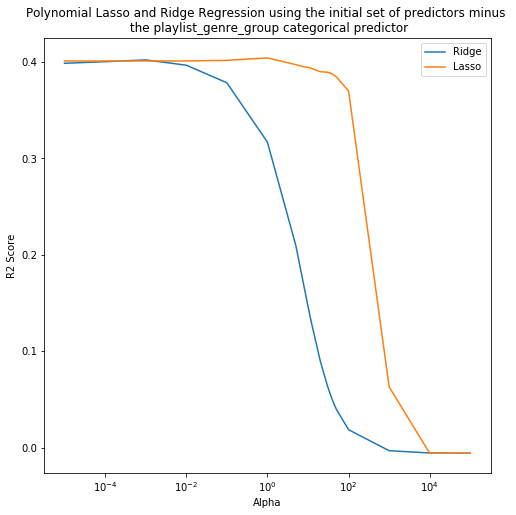

Best Lasso: 1 score: 0.404260035553
Best Ridge: 0.001 score: 0.402170322728


(0.40217032272775133, 0.40426003555265244)

In [369]:
lasso_ridge_poly(get_dataframe_outliers(500000))

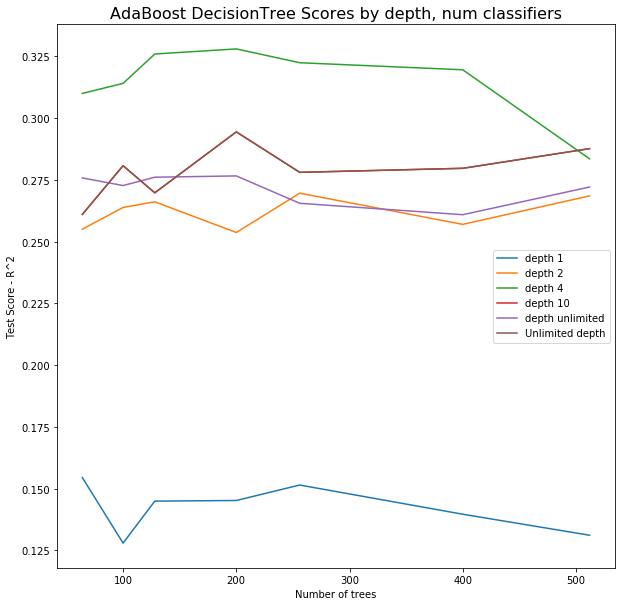

Best score for depth 1 is 0.154467772877 with 64 trees
Best score for depth 2 is 0.269614144875 with 256 trees
Best score for depth 4 is 0.328021608893 with 200 trees
Best score for depth 10 is 0.294432954978 with 200 trees
Best score for depth unlimited is 0.276596438404 with 200 trees


In [358]:
decision_tree_ada(get_dataframe_outliers(500000))

#### Determining the best outlier follower threshold

In [406]:
# 100,000 to 3,000,000 in steps of 100,000
thresholds = list(np.arange(100000, 3000000, 100000))

# Append 10,000,000 to get rid of that final data point
thresholds.append(10000000)

scores = []
for threshold in thresholds:
    # Return scores only, do not print
    scores.append(lasso_ridge_one_hot(get_dataframe_outliers(threshold), False))

/Users/rmitchell/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


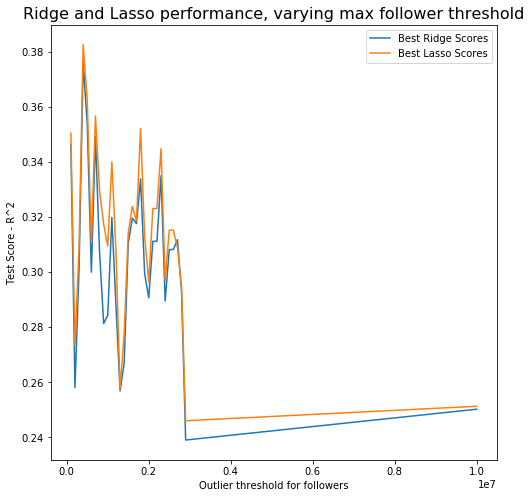

In [409]:
# Plot outlier threshold visualization using data retrieve above
plt.figure(figsize=(8,8))
plt.plot(thresholds, [score[0] for score in scores], label='Best Ridge Scores')
plt.plot(thresholds, [score[1] for score in scores], label='Best Lasso Scores')
plt.title('Ridge and Lasso performance, varying max follower threshold', fontsize = 16)
plt.xlabel('Outlier threshold for followers')
plt.ylabel('Test Score - R^2')
plt.legend(loc='best')
plt.show()